In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

/bin/bash: line 1: nvidia-smi: command not found
Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
notebook_dir = "/content/drive/MyDrive/Colab Notebooks/Cattle_Identification"

from google.colab import drive
drive.mount('/content/drive')
import sys
import os
sys.path.insert(0, notebook_dir)
os.chdir(notebook_dir)

Mounted at /content/drive


In [ ]:
def individual_sample_dict(url):
  """
  Parse the dataset's URL and generate a dictionary whose key is the cattle ID and
  value is a list of pairs of sample number and image URL
  Args:
      url: the URL of the dataset.
  Returns:
      individual_sample_dict: A dictionary: {'cattle_000': [('000', image_url),('001', image_url) ...] ... }
  """
  import requests
  response = requests.get(url)
  individual_sample_dict = {}
  for line in response.text.split('"name":'):
    if '"contentType":"directory"' and 'cattle_' in line:
      individual = line.split('"')[1].split('"')[0]
      response1 = requests.get(url + individual)
      sample_list = []
      for line1 in response1.text.split('"name":'):
        if '"contentType":"file"' and '.png' in line1:
          sample = line1.split('"')[1].split('.png')[0]
          sample_list.append((sample, 'https://raw.githubusercontent.com/pwang697/Cattle_Identification/main/images/' + individual + '/' + sample + '.png' ))
      individual_sample_dict[individual] = sample_list

  return individual_sample_dict

dataset_dict = individual_sample_dict("https://github.com/pwang697/Cattle_Identification/tree/main/images/")


In [ ]:
def retrieve_image(url, local_path):
  """
  Retrieve and download image
  """
  import requests
  response = requests.get(url)
  if response.status_code == 200:
      with open(local_path, 'wb') as file:
          file.write(response.content)
      print(f"Image downloaded successfully: {local_path}")
  else:
      print(f"Failed to retrieve image. Status code: {response.status_code}")


In [ ]:
def known_unknown_split(dataset_dict, known_rate):
  import random
  random.seed(0)
  n_known = int(len(dataset_dict)*known_rate)
  known_keys = random.sample(dataset_dict.keys(), n_known)
  known_dict = {}
  unknown_dict = {}
  for key in dataset_dict.keys():
    if key in known_keys:
      known_dict[key] = dataset_dict[key]
    else:
      unknown_dict[key] = dataset_dict[key]
  return known_dict, unknown_dict

In [ ]:
known_dict, unknown_dict = known_unknown_split(dataset_dict, 0.1)

<ipython-input-6-29faee4a7c0a>:5: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  known_keys = random.sample(dataset_dict.keys(), n_known)


In [ ]:
unknown_dict.keys()

dict_keys(['cattle_000', 'cattle_001', 'cattle_002', 'cattle_003', 'cattle_004', 'cattle_006', 'cattle_007', 'cattle_008', 'cattle_009', 'cattle_010', 'cattle_011', 'cattle_012', 'cattle_013', 'cattle_014', 'cattle_015', 'cattle_016', 'cattle_017', 'cattle_018', 'cattle_019', 'cattle_020', 'cattle_021', 'cattle_022', 'cattle_023', 'cattle_024', 'cattle_025', 'cattle_026', 'cattle_027', 'cattle_028', 'cattle_029', 'cattle_030', 'cattle_031', 'cattle_032', 'cattle_034', 'cattle_035', 'cattle_036', 'cattle_037', 'cattle_039', 'cattle_040', 'cattle_041', 'cattle_042', 'cattle_043', 'cattle_044', 'cattle_045', 'cattle_046', 'cattle_047', 'cattle_048', 'cattle_050', 'cattle_052', 'cattle_054', 'cattle_055', 'cattle_056', 'cattle_057', 'cattle_058', 'cattle_059', 'cattle_060', 'cattle_063', 'cattle_064', 'cattle_066', 'cattle_067', 'cattle_068', 'cattle_069', 'cattle_070', 'cattle_071', 'cattle_072', 'cattle_073', 'cattle_074', 'cattle_075', 'cattle_076', 'cattle_077', 'cattle_078', 'cattle_0

In [ ]:
def naive_train_test_split(dataset_dict):
  """
  Separate two samples from each individual
  """
  import random
  random.seed(0)
  train_dict = {}
  test_dict = {}
  for item in dataset_dict:
    temp_list = dataset_dict[item].copy()
    random_samples = random.sample(temp_list, 2)
    test_dict[item] = random_samples
    for rs in random_samples:
      temp_list.remove(rs)
    train_dict[item] = temp_list
  return train_dict, test_dict

In [ ]:
train_dict, test_dict = naive_train_test_split(known_dict)
test_dict['cattle_005']

[('006',
  'https://raw.githubusercontent.com/pwang697/Cattle_Identification/main/images/cattle_005/006.png'),
 ('009',
  'https://raw.githubusercontent.com/pwang697/Cattle_Identification/main/images/cattle_005/009.png')]

In [ ]:
def make_local_image_dataset(dataset_dict, directory):
  if os.path.isdir(directory):
    print(f"Directory existed: {directory}")
  else:
    os.mkdir(directory)
    for item in dataset_dict:
      os.mkdir(directory + '/' + item)
      for sample in dataset_dict[item]:
        local_path = directory + '/' + item + '/' + sample[0] + '.png'
        retrieve_image(sample[1], local_path)

train_dir = notebook_dir + '/' + 'train'
test_dir = notebook_dir + '/' + 'test'
eval_dir = notebook_dir + '/' + 'eval'
make_local_image_dataset(train_dict, train_dir)
make_local_image_dataset(test_dict, test_dir)
make_local_image_dataset(unknown_dict, eval_dir)

Image downloaded successfully: /content/drive/MyDrive/Colab Notebooks/Cattle_Identification/train/cattle_005/000.png
Image downloaded successfully: /content/drive/MyDrive/Colab Notebooks/Cattle_Identification/train/cattle_005/001.png
Image downloaded successfully: /content/drive/MyDrive/Colab Notebooks/Cattle_Identification/train/cattle_005/002.png
Image downloaded successfully: /content/drive/MyDrive/Colab Notebooks/Cattle_Identification/train/cattle_005/003.png
Image downloaded successfully: /content/drive/MyDrive/Colab Notebooks/Cattle_Identification/train/cattle_005/004.png
Image downloaded successfully: /content/drive/MyDrive/Colab Notebooks/Cattle_Identification/train/cattle_005/005.png
Image downloaded successfully: /content/drive/MyDrive/Colab Notebooks/Cattle_Identification/train/cattle_005/007.png
Image downloaded successfully: /content/drive/MyDrive/Colab Notebooks/Cattle_Identification/train/cattle_005/008.png
Image downloaded successfully: /content/drive/MyDrive/Colab Note

In [ ]:
def add_black_canva(img, height, width):
  """
  Performs adding black canvas under input image

  Parameters
  -----------------------
  img: input image
  height: height of canvas (height of output image)
  width: width of canvas (width of output image)
  """
  import numpy as np
  black_canva = np.zeros((height,width,3), dtype=np.uint8)
  rows, cols = img.shape[:2]
  start_x, start_y = width//2 - cols//2, height//2 - rows//2
  black_canva[start_y:start_y+rows, start_x:start_x+cols] = img
  return black_canva

In [ ]:
def generate_numpy_arr_dataset(directory):
  import cv2
  import numpy as np
  dir_list = os.listdir(directory)
  X_list = []
  y_list = []
  for dir in dir_list:
    file_list = os.listdir(directory + '/' + dir)
    dir_int = int(dir.split('_')[1])
    for img in file_list:
      img_array = cv2.imread(directory + '/' + dir + '/' + img)
      # black_canva = add_black_canva(img_array, 1000, 1000)
      # resize_img = cv2.resize(black_canva,(256,256))
      resize_img = cv2.resize(img_array,(224,224))
      X_list.append(resize_img)
      y_list.append(dir_int)
  X_array = np.array(X_list, dtype=np.uint8)
  y_array = np.array(y_list, dtype=np.uint8)
  return X_array, y_array

In [ ]:
X_train, y_train = generate_numpy_arr_dataset(train_dir)
X_test, y_test = generate_numpy_arr_dataset(test_dir)
X_eval, y_eval = generate_numpy_arr_dataset(eval_dir)

In [ ]:
X_train.shape

(71, 224, 224, 3)

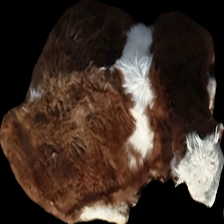

In [ ]:
from google.colab.patches import cv2_imshow
example = cv2_imshow(X_train[0])

In [ ]:
import numpy as np
np.savez(notebook_dir + '/datasets/10-90/resize/train.npz', images = X_train, labels = y_train)
np.savez(notebook_dir + '/datasets/10-90/resize/test.npz', images = X_test, labels = y_test)
np.savez(notebook_dir + '/datasets/10-90/resize/eval.npz', images = X_eval, labels = y_eval)